# Methods for Local Interpretations

In contrast with global interpretations, local interpretations seek to attribute the prediction of a particular data instance to certain feature-value combinations. In this chapter, we will look at two commonly used local interpretation methods: Local Interpretable Model-agnostic Explanations (LIME) proposed by {cite:t}`ribeiro2016should` and SHapley Additive exPlanation (SHAP) proposed by {cite:t}`lundberg2017unified`.

For demonstration, we will use the same Bank Marketing dataset as in Chapter {doc}`2-2-global` and apply the same data pre-processing.

In [4]:
# import data
import pandas as pd
bank = pd.read_csv('../data/bank-full.csv', sep=';')
X = bank.drop('y', axis = 1)
Y = bank['y']
# converting categorical variables to dummies
X = pd.get_dummies(X, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'], dtype=int)
# converting yes / no in outcome variable to 1 / 0
Y = Y.map(dict(yes = 1, no = 0))

In [5]:
# for illustration, let's build a random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# we will use 70% of the data for training and 30% for testing
# setting random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

# train the random forest classifier
# this dataset is quite imbalanced, so we will set class_weight to balanced
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

## Individual Conditional Expectation (ICE) Plot

The ICE plot {cite:p}`goldstein2015peeking` is essentially PDP for individual data points (hence a local interpretation method). Recall that in making PDP, we average over the prediction values obtained from varying the other features. In contrast, ICE generates one line per data point, and the values of other features are simply fixed as the realized values of each data point. Please note that ICE plot may not be appropriate when you have a very large dataset to visualize.

```{admonition} Maths behind ICE (optional, toggle to show)
:class: dropdown
Using the same notations as in the last chapter, consider the ICE plot for a particular data point where the focal features is $X_1$ and the other feature $X_2$ takes value $x_2$. ICE simply computes

$$
f_{1,ICE}(x_1) = f(x_1, x_2)
$$
then plots $f_{1,ICE}(x_1)$ against $x_1$ for different values of $x_1$.
```

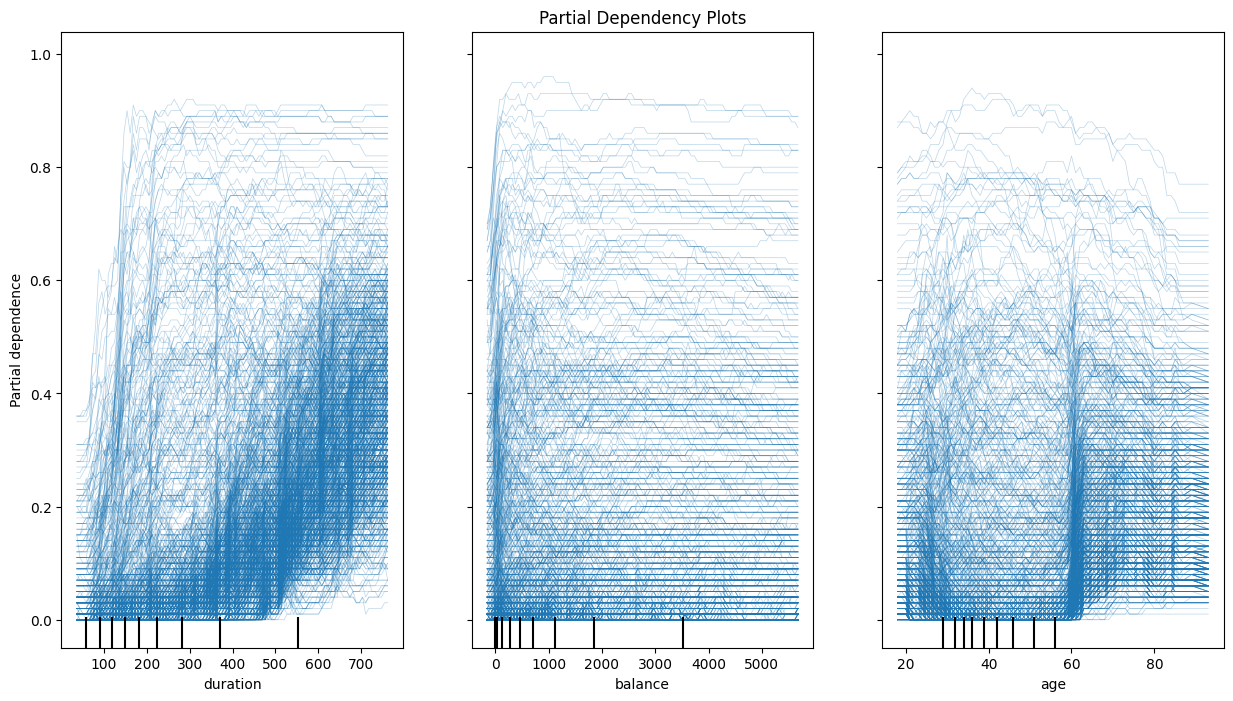

In [6]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
# let's get ICE of the above random forest classifier for feature "duration", "balance", and "age"
# the syntax is almost the same as PDP, except that we set kind='individual'
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Partial Dependency Plots")
PartialDependenceDisplay.from_estimator(estimator = rf_clf, 
                                        X = X_test, 
                                        features = ["duration", "balance", "age"],
                                        kind = "individual",
                                        ax = ax)

## Local Interpretable Model-Agnostic Explanations (LIME)

LIME {cite:p}`ribeiro2016should` is an important model-agnostic approach for obtaining local interpretations. LIME learns an interpretation for a given data instance $x$ by following three steps:
- Sample from training data some data instances $S$ that are close to $x$;
- Apply a prediction model $f(.)$ to obtain predictions (predicted probabilities for a classifier) $f(s)$ for each $s \in S$;
- Run a regression on sampled data $S$, with $f(s)$ as outcome variable and features as independent variables, report estimated coefficients as the interpretations of the effect of each feature on the prediction.

Conceptually, LIME tries to explain the prediction on a given data instance by fitting a **local interpretable (linear) model** to training data surrounding that data instance.

```{admonition} More details behind LIME (optional, toggle to show)
:class: dropdown
More precisely, LIME does a few more things. First, for each surrounding training data $s \in S$, LIME computes a similarity score $d(s, x)$ to quantify how close it is to $x$. Second, before estimating a linear regression. It applies LASSO to select relevant features. Finally, it estimates a linear regression of $f(s)$ on LASSO-selected features, with $d(s, x)$ as weights (i.e., a weighted least square estimation).

In [7]:
import lime.lime_tabular

# the LIME implementation requires numpy arrays as input
feature_names = X.columns.tolist()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# initialize the LIME explainer object
# we need to pass the training data, feature names, and names of the classes
# discretize_continuous set to TRUE for continuous features
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                        feature_names = feature_names, 
                                                        class_names = ['no', 'yes'],
                                                        discretize_continuous = True, random_state = 42)
# next we can apply the explainer for a single instance
# num_features: maximum number of features present in explanation
exp = lime_explainer.explain_instance(X_test[2], rf_clf.predict_proba, num_features = 10)
# visualize the explanation
# show_table and show_all will display the feature values of this data instance in table format
exp.show_in_notebook(show_table = True, show_all = True)

c:\Users\yang3653\AppData\Local\anaconda3\envs\responsibleai\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Here, we can see that the LIME-generated explanation for the third testing data instance. It receives a predicted probabilities of 0.93 for being in the "no" class, due to features such as month, default, and job category. The number on top of each bar is the estimated coefficient value.

## SHapley Additive exPlanations (SHAP)

Another popular interpretation method is SHAP {cite:p}`lundberg2017unified`. For a given data instance to be explained, SHAP computes an importance score for each feature that measures the change in prediction (or predicted probability in the case of classification) that can be attributed to the said feature. It is based on the idea of [Shapley Value](https://en.wikipedia.org/wiki/Shapley_value) in game theory, which is a way to measure the "individual contribution" of a player in a cooperative game. Analogously, when interpreting ML predictions, you can think about each feature as a "player" and SHAP value quantifies its "contribution" to a prediction.

In [7]:
import shap
# compute SHAP values based on a random sample of 100 training data instances, to save computation time
shap_explainer = shap.KernelExplainer(lambda x: rf_clf.predict_proba(x)[:,1], shap.sample(X_train, 100, random_state = 42))
shap_values = shap_explainer.shap_values(X_test[2])
# try print out shap_values, it should be an array with length same as number of features
#print(shap_values)

c:\Users\yang3653\AppData\Local\anaconda3\envs\responsibleai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# visualize the explanation
shap.initjs()
shap.force_plot(base_value = shap_explainer.expected_value, 
                shap_values = shap_values, 
                features = X_test[2], feature_names = feature_names)

This is called a **force plot**, and there are a lot of components in this visualization:
- The "base value" is the average predicted probability (of class "yes") among the 100 randomly sampled training data used to estimated SHAP values. This corresponds to the ```shap_explainer.expected_value``` value in the code;
- The number 0.07 $f(x)$ is the actual predicted probability of the instance being explained;
- Red features have a positive impact on predicted probability (a force pushing right) and blue features have a negative impact on predicted probability (a foce pushing left);
- On both the red and blue sides, features are ordered based on their SHAP values, so more "important" features are closer to the center.